In [4]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display_png

### Supprt Vector Machine : SVM

線形、非線形の分類・回帰・外れ値検出ができる強力かつ柔軟な機械学習モデル  
中小規模のデータセットの分類に特に適している  
分類境界になるべく余裕を持たせる（データと境界の間のマージンを多くする）ことを目的にした手法  
未学習データに対しても良い性能を発揮  
分類境界はそのままのSVMでは超平面に限られるが、適当な写像を挟むことで非線形分類も可能（Kernel　SVM）

Q. サポートってどういうこと？  
A. 下の図のようにマージンを計算する時、各クラスで境界に一番近いサンプルだけが評価関数に寄与する。（ハードマージンの場合）  
このベクトルが計算をサポートしているのでSupport Vectorと呼ばれる


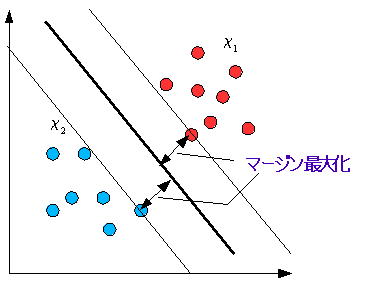

In [7]:
display_png(Image('./SVM_scheme.png'))

計算過程は  
①マージン定義　  
② Laglangeの未定乗数法をKKT条件（不等式制約条件が使える）で適用   
③ 導出されたLaglange未定乗数を勾配法で解く（凸関数なんので必ず最適解に収束） 


In [9]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [70]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

#     svs = svm_clf.support_vectors_
#     plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)
    
# 決定境界で色分けする関数
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100) # 要求された軸の範囲で100個に区切る
    x1s = np.linspace(axes[2], axes[3], 100) # 上に同じ
    x0, x1 = np.meshgrid(x0s, x1s) # メッシュを生成
    X = np.c_[x0.ravel(), x1.ravel()] # 軸を一次元化して結合（各グリッドでの予測結果を計算する）
    y_pred = clf.predict(X).reshape(x0.shape) # 予測結果のshapeを合わせる
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

In [69]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # 花弁の長さと幅
y = (iris["target"] == 2).astype(np.float64) # 2:Verginica 種について取り出す

scaler = StandardScaler()
linear_svc = LinearSVC(C=1, loss="hinge", random_state=42) # SVCはSupport Vector Classificationの略。Cはソフトマージンのエラーペナルティ

svm_clf = Pipeline([
    ("scaler", scaler), # 各入力データのスケーリング
    ("linear_svc", linear_svc)
])

svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

In [47]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

In [48]:
b1 = linear_svc.decision_function([-scaler.mean_ / scaler.scale_])
w1 = linear_svc.coef_[0] / scaler.scale_
linear_svc.intercept_ = np.array([b1])
linear_svc.coef_ = np.array([w1])

In [49]:
linear_svc.__dict__.keys()

dict_keys(['dual', 'tol', 'C', 'multi_class', 'fit_intercept', 'intercept_scaling', 'class_weight', 'verbose', 'random_state', 'max_iter', 'penalty', 'loss', 'classes_', 'coef_', 'intercept_', 'n_iter_'])

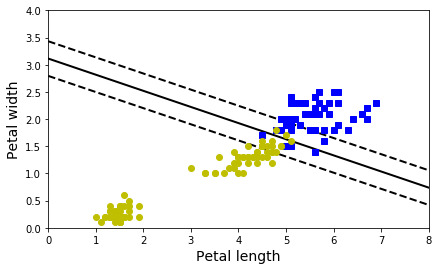

In [66]:
plt.figure(figsize=(15,4))

plt.subplot(121)
plot_svc_decision_boundary(linear_svc, 0, 8)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([0, 8, 0, 4])

plt.show()

### 多項式カーネルSVM

多項式の特徴量を追加することで非線形な分離が可能になる（特徴量の多項式を新たな特徴量とし、その空間内でSVMを適用する）

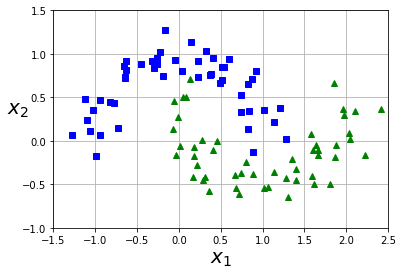

In [74]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs") # sはsquare(?)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^") # ^ は三角
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20) # r"$$"で挟むとTex的に数式を書ける
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

これは超平面での（この場合直線での）分割は難しい。。。

線形分離不可能


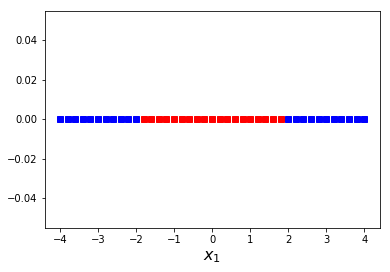

特徴量の多項式を加えることで非線形な分離を可能にする


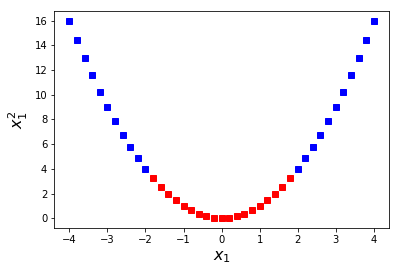

In [135]:
x_1_1 = np.hstack((np.linspace(-4, -2, 11), np.linspace(2, 4, 11) ))
x_1_2 = np.linspace(-1.8, 1.8, 19)
x_2_1 = np.linspace(0, 0, 22)
x_2_2 = np.linspace(0, 0, 19)

print('線形分離不可能')
plt.figure()
plt.plot(x_1_1, x_2_1, 'bs')
plt.plot(x_1_2, x_2_2, 'rs')
plt.xlabel(r'$x_1$', fontsize=16)
plt.show()

print('特徴量の多項式を加えることで非線形な分離を可能にする')
plt.figure()
plt.plot(x_1_1, x_1_1**2, 'bs')
plt.plot(x_1_2, x_1_2**2, 'rs')
plt.xlabel(r'$x_1$', fontsize=16)
plt.ylabel(r'$x_1^2$', fontsize=16)
plt.show()

In [148]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf_1 = Pipeline([
        ("poly_features", PolynomialFeatures(degree=1)), # ここで3次までの多項式特徴量を追加する、あとはスケーリングと線形SVM
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])
polynomial_svm_clf_2 = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2)), # ここで3次までの多項式特徴量を追加する、あとはスケーリングと線形SVM
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])
polynomial_svm_clf_3 = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)), # ここで3次までの多項式特徴量を追加する、あとはスケーリングと線形SVM
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])
polynomial_svm_clf_20 = Pipeline([
        ("poly_features", PolynomialFeatures(degree=20)), # ここで3次までの多項式特徴量を追加する、あとはスケーリングと線形SVM
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf_1.fit(X, y)
polynomial_svm_clf_2.fit(X, y)
polynomial_svm_clf_3.fit(X, y)
polynomial_svm_clf_20.fit(X, y)

Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=20, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

特徴量そのまま


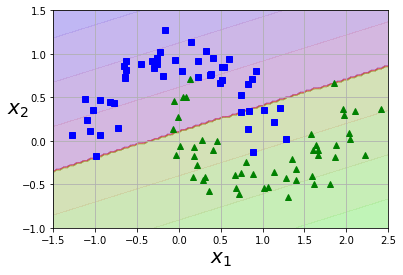

特徴量の2次の項を追加


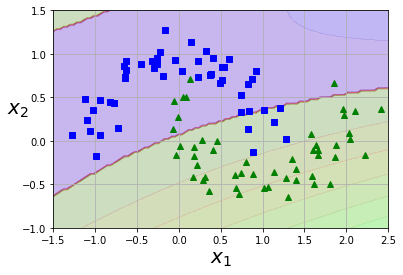

特徴量の3次の項まで追加


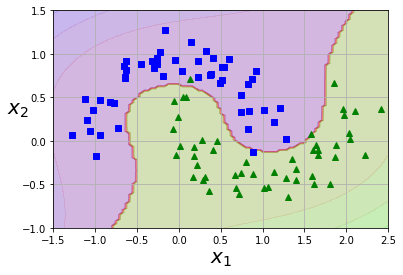

特徴量の20次の項まで追加


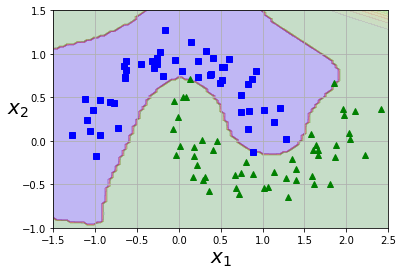

In [150]:
print('特徴量そのまま')
plt.figure()
plt.subplot(111)
plot_predictions(polynomial_svm_clf_1, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()
print('特徴量の2次の項を追加')
plt.figure()
plot_predictions(polynomial_svm_clf_2, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()
print('特徴量の3次の項まで追加')
plt.figure()
plot_predictions(polynomial_svm_clf_3, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()
print('特徴量の20次の項まで追加')
plt.figure()
plot_predictions(polynomial_svm_clf_20, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

ちゃんと非線形な決定境界を求められている。  
多項式だけでも結構対応可能な例が多そう